In [136]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.metrics import roc_curve, auc, log_loss
from sklearn.metrics import classification_report, precision_recall_curve, auc
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from tqdm import tqdm

import torch 
import os
import torch

import warnings
warnings.filterwarnings("ignore")

In [140]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test.csv"
test_data = pd.read_csv(test_data_path)

In [141]:
keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']

data_classification = data.copy()
test_classification = test_data.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)

In [142]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [132]:
import matplotlib.pyplot as plt

def plot_all_prc_curves(results_summary):
    plt.figure(figsize=(8, 6))

    for result in results_summary:
        method = result['Method']
        
        # PRC 곡선 데이터 로딩
        y_prob = result.get('y_prob')
        y_test = result.get('y_test')
        
        if y_prob is None or y_test is None:
            continue  # 저장되지 않은 경우 건너뜀

        precision, recall, _ = precision_recall_curve(y_test, y_prob)
        auprc = auc(recall, precision)
        plt.plot(recall, precision, label=f'{method} (au_prc={auprc:.3f})')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve Comparison')
    plt.legend(loc='lower left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [157]:
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc

from sklearn.utils import shuffle

results_summary = []

def method_evaluation(model, data_x, data_y, X_test, y_test, method):
    print(f"Preprocessing method : {method}")

    if method == 'Base':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2,
                                                           random_state=42, stratify=data_y)
        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        verbose=True
        )

        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)

    elif method == 'Undersampling':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.13, random_state=42, stratify=data_y)
        undersampler = RandomUnderSampler(random_state=42)
        X_under, y_under = undersampler.fit_resample(X_train, y_train)

        data_under = pd.concat([pd.DataFrame(X_under, columns=data_x.columns), pd.DataFrame(y_under, columns=['loan_status'])], axis=1)
        X_train = data_under.drop(columns=['loan_status'])  # Feature (입력 데이터)
        y_train = data_under[['loan_status']]  # Target (타겟 변수)

        model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
        verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)

    elif method == 'SMOTE':
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, random_state=42, stratify=data_y)

        smote = SMOTE(random_state=42)

        X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

        augmentation_data = pd.concat([X_train_smote, y_train_smote], axis = 1)
        X_train = augmentation_data.drop(columns='loan_status')
        y_train = augmentation_data[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    
    elif method == 'table-gan':
        #Fake dataset
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/return_feature/return_feature_OI_11_00_fake.csv"
        fake = pd.read_csv(fake_path)
        fake['loan_status'] = 1
        
        keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']
        fake_Classification = fake.copy()
        fake_Classification = fake_Classification.drop(columns = keep_features)

        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.33, random_state=42, stratify=data_y)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total, random_state=42)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)

    elif method == 'Smotified-gan':
        fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/smotified_fake_data.csv"
        fake = pd.read_csv(fake_path)

        #keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv']
        fake_Classification = fake.copy()
        #fake_Classification = fake_Classification.drop(columns = keep_features)
        
        X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)
        train_dataset = pd.concat([X_train, y_train], axis=1)
        
        train_total = pd.concat([train_dataset,fake_Classification])
        train_total = shuffle(train_total, random_state=42)

        X_train = train_total.drop(columns='loan_status')
        y_train = train_total[['loan_status']]

        model.fit(
            X_train, y_train,
            eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
            verbose=True
        )
        y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

        threshold = 0.5
        y_pred = (y_prob >= threshold).astype(int)
    

    precision_0 = precision_score(y_test, y_pred, pos_label=0)
    recall_0 = recall_score(y_test, y_pred, pos_label=0)
    f1_0 = f1_score(y_test, y_pred, pos_label=0)

    precision_1 = precision_score(y_test, y_pred, pos_label=1)
    recall_1 = recall_score(y_test, y_pred, pos_label=1)
    f1_1 = f1_score(y_test, y_pred, pos_label=1)

    precision, recall, _ = precision_recall_curve(y_test, y_prob)
    au_prc = auc(recall, precision)

    results_summary.append({
    'Method': method,
    'Recall_0': round(recall_0, 2),
    'Precision_0': round(precision_0, 2),
    'F1_0': round(f1_0, 2),
    'Recall_1': round(recall_1, 2),
    'Precision_1': round(precision_1, 2),
    'F1_1': round(f1_1, 2),
    'AU_PRC': round(au_prc, 2),
    'y_prob': y_prob,
    'y_test': y_test.squeeze()  
    })

In [158]:
Methods = ['Base', 'Undersampling', 'SMOTE', 'table-gan','Smotified-gan']

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification['loan_status']

returns_df = pd.DataFrame()

for method in Methods:
    data_x = data_classification.drop(columns='loan_status')
    data_y = data_classification['loan_status']

    model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.01,
        objective='binary:logistic',
        eval_metric="logloss",
        random_state=42,
        verbosity=0
    )

    method_evaluation(model, data_x, data_y, X_test, y_test, method)

results_df = pd.DataFrame(results_summary)

Preprocessing method : Base
[0]	validation_0-logloss:0.49199	validation_1-logloss:0.49201
[1]	validation_0-logloss:0.48743	validation_1-logloss:0.48747
[2]	validation_0-logloss:0.48300	validation_1-logloss:0.48305
[3]	validation_0-logloss:0.47868	validation_1-logloss:0.47875
[4]	validation_0-logloss:0.47446	validation_1-logloss:0.47455
[5]	validation_0-logloss:0.47036	validation_1-logloss:0.47047
[6]	validation_0-logloss:0.46636	validation_1-logloss:0.46648
[7]	validation_0-logloss:0.46246	validation_1-logloss:0.46260
[8]	validation_0-logloss:0.45865	validation_1-logloss:0.45880
[9]	validation_0-logloss:0.45493	validation_1-logloss:0.45510
[10]	validation_0-logloss:0.45130	validation_1-logloss:0.45148
[11]	validation_0-logloss:0.44775	validation_1-logloss:0.44795
[12]	validation_0-logloss:0.44428	validation_1-logloss:0.44450
[13]	validation_0-logloss:0.44088	validation_1-logloss:0.44111
[14]	validation_0-logloss:0.43757	validation_1-logloss:0.43781
[15]	validation_0-logloss:0.43432	val

In [159]:
results_df

,Method,Recall_0,Precision_0,F1_0,Recall_1,Precision_1,F1_1,AU_PRC,y_prob,y_test
0,Base,0.93,0.94,0.94,0.75,0.73,0.74,0.79,"[0.04567911, 0.7788913, 0.006111081, 0.7285830...",0 0 1 1 2 0 3 ...
1,Undersampling,0.86,0.97,0.91,0.91,0.61,0.73,0.78,"[0.12540011, 0.93529963, 0.020424021, 0.907723...",0 0 1 1 2 0 3 ...
2,SMOTE,0.89,0.96,0.93,0.86,0.65,0.74,0.76,"[0.0508383, 0.9117276, 0.017381096, 0.9275828,...",0 0 1 1 2 0 3 ...
3,table-gan,0.88,0.96,0.92,0.85,0.63,0.72,0.70,"[0.19199778, 0.8230492, 0.011055981, 0.8253497...",0 0 1 1 2 0 3 ...
4,Smotified-gan,0.88,0.97,0.92,0.88,0.63,0.74,0.74,"[0.15515094, 0.8905995, 0.015976347, 0.8594346...",0 0 1 1 2 0 3 ...


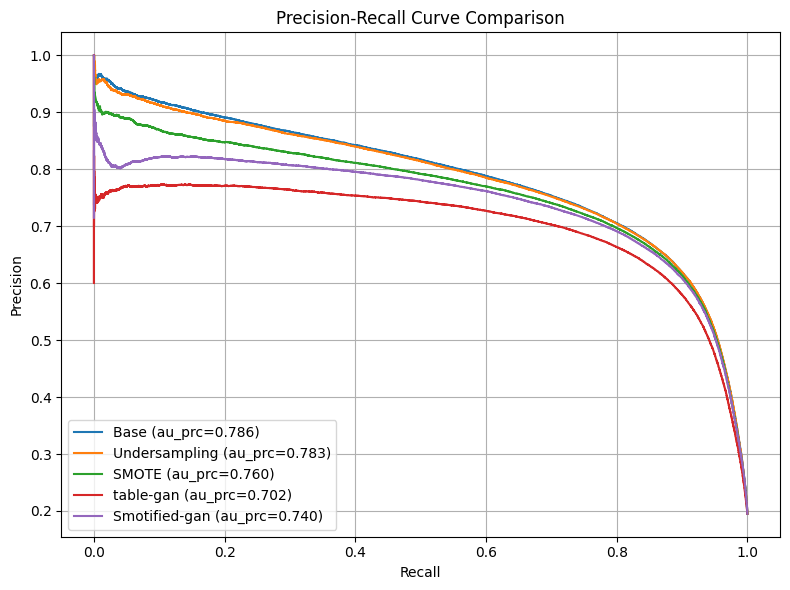

In [160]:
plot_all_prc_curves(results_summary)

## SMOTified - GAN 적용

In [11]:
data['loan_status'].value_counts()

loan_status
0    898669
1    217789
Name: count, dtype: int64

In [12]:
data_x = data.drop(columns='loan_status')
data_y = data['loan_status']  # Series로 사용해야 fit_resample 가능

# 2. class 분포 확인
class_0_count = data_y.value_counts()[0]
target_class_1 = class_0_count // 2  # class 1을 class 0의 절반으로 맞추기

# 3. sampling_strategy 설정
# 'minority': 전체 맞춤, float: 전체에 대한 비율, dict: 직접 수 지정
sampling_strategy = {0: class_0_count, 1: target_class_1}

# 4. SMOTE 적용
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(data_x, data_y)

# 5. 결과 결합
augmentation_data = pd.concat([X_train_smote, y_train_smote], axis=1)

In [13]:
augmentation_data['loan_status'].value_counts()

loan_status
0    898669
1    449334
Name: count, dtype: int64

In [ ]:
"""class_1_oversampled = augmentation_data[augmentation_data['loan_status'] == 1]

oversample_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
class_1_oversampled.to_csv(path_or_buf=oversample_path+"oversampled.csv", index=False)"""

## Stratified - Tablegan modeling

In [105]:
## Load original data
data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_train.csv"
data = pd.read_csv(data_path, low_memory=False)

##load test data
test_data_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/return_feature_test.csv"
test_data = pd.read_csv(test_data_path)

#Fake dataset
fake_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/tablegan/samples/oversampled/oversampled_OI_11_00_fake.csv"
fake = pd.read_csv(fake_path)
fake['loan_status'] = 1

common_wrong_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/commom_wrong.csv"
common_wrong = pd.read_csv(common_wrong_path)

In [106]:
common_wrong = common_wrong[common_wrong['loan_status'] == 1]

In [107]:
for col in fake.columns:
    print(f"{col} feature values :\n{fake[col].unique()}\n")

last_fico_range_high feature values :
[509.90686799 606.46766027 539.47776623 ... 533.59792565 589.15562484
 688.5025652 ]

mo_sin_old_rev_tl_op feature values :
[ 97.59966593 260.02374805 138.72929581 ... 183.70084772  89.19023542
 166.27553025]

int_rate feature values :
[0.1757991  0.14665343 0.14700958 ... 0.11543785 0.11779421 0.17829609]

annual_inc feature values :
[102475.38248401 139593.93767375 143365.33337195 ...  21459.53776306
  48242.83368029  22388.45626117]

dti feature values :
[15.44312931  9.39905781 13.1427337  ...  4.95516859 14.80646956
 26.82932831]

installment feature values :
[244.38       912.44471909 656.51184631 ... 130.64329073 922.03673451
 608.37698847]

zip_code feature values :
[378.54160994 145.62329199 905.88455456 ... 714.02926085 944.24425136
 496.69844781]

revol_util feature values :
[0.72643549 0.84496543 0.56175871 ... 0.03151235 0.2744155  0.52175442]

fico_range_low feature values :
[660.48123548 663.51065965 685.82205494 ... 685.5074022  669

In [108]:
## Term months preprocessing
def term_months(x):
    return 36 if abs(x-36)<abs(x-60) else 60

fake['term_months'] = fake['term_months'].apply(term_months)

In [5]:
fake['term_months'].value_counts()

term_months
36    277091
60    182909
Name: count, dtype: int64

In [109]:
keep_features = ['grade', 'term_months', 'total_pymnt', 'total_pymnt_inv','total_il_high_credit_limit', 'loan_amnt']

data_classification = data.copy()
test_classification = test_data.copy()
fake_Classification = fake.copy()

data_classification = data_classification.drop(columns = keep_features)
test_classification = test_classification.drop(columns = keep_features)
fake_Classification = fake_Classification.drop(columns = keep_features)

In [110]:
fake_Classification2 = pd.concat([fake_Classification, common_wrong])

In [119]:
train_path = "C:/Users/GCU/Lending_club/Data_Analysis_lending-club/Dataset/"
fake_Classification2.to_csv(path_or_buf=train_path+"smotified_fake_data.csv", index=False)

In [111]:
len(fake_Classification2)

559051

In [ ]:
"""import numpy as np
from sklearn.metrics.pairwise import cosine_distances
from tqdm import tqdm  # 진행 표시줄

# ✅ 설정
batch_size = 1000  # 한 번에 계산할 fake 샘플 수
threshold = 0.3    # 거리 기준 (선택 기준)

# ✅ 결과 저장 리스트
min_distances = []
selected_indices = []

# ✅ 전체 batch loop
for i in tqdm(range(0, len(fake_Classification), batch_size)):
    batch = fake_Classification[i:i + batch_size]

    # 거리 계산 (각 fake 샘플 ↔ test 샘플)
    dists = cosine_distances(batch, test_classification)

    # 최소 거리 계산
    min_dist_batch = dists.min(axis=1)
    min_distances.extend(min_dist_batch)

    # threshold 이하 거리인 샘플 인덱스 저장
    for j, dist in enumerate(min_dist_batch):
        if dist < threshold:
            selected_indices.append(i + j)

# ✅ 선택된 샘플 추출
selected_fake = fake_Classification[selected_indices]

# 결과 확인
print(f"총 {len(selected_indices)}개의 fake 샘플이 test와 유사하다고 판단되어 선택됨.")
"""

  0%|          | 1/540 [00:12<1:54:13, 12.72s/it]

In [112]:
data_x = data_classification.drop(columns='loan_status')
data_y = data_classification[['loan_status']]

X_test = test_classification.drop(columns='loan_status')
y_test = test_classification[['loan_status']]

In [113]:
# data under 6:2:2 train,val,test set
X_train, X_val, y_train, y_val = train_test_split(data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)

print(f"Train size: {X_train.shape[0]} samples ({X_train.shape[0]/len(data):.1%})")
print(f"Validation size: {X_val.shape[0]} samples ({X_val.shape[0]/len(data):.1%})")
print(f"Test size: {X_test.shape[0]} samples ({X_test.shape[0]/len(data):.1%})")

Train size: 893166 samples (80.0%)
Validation size: 223292 samples (20.0%)
Test size: 744306 samples (66.7%)


In [114]:
from sklearn.utils import shuffle

train_dataset = pd.concat([X_train, y_train], axis=1)
train_total = pd.concat([train_dataset,fake_Classification2])
train_total = shuffle(train_total, random_state=42)

In [115]:
X_train = train_total.drop(columns='loan_status')
y_train = train_total[['loan_status']]

In [44]:
train_total['loan_status'].value_counts()

loan_status
1    733282
0    718935
Name: count, dtype: int64

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier

#pos, neg = y_test.value_counts()  # ✅ `.values`로 NumPy 배열 변환
#scale_pos_weight = neg / pos  # 클래스 비율 계산

"""# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    tree_method='hist',           
    grow_policy='lossguide',      
    max_leaves=64,               
    learning_rate=0.01,
    n_estimators=500,
    eval_metric='logloss',
    random_state=42
)"""

# 1️⃣ XGBoost 모델 정의
model = XGBClassifier(
    #scale_pos_weight=scale_pos_weight, 
    n_estimators=500,
    learning_rate=0.01,
    objective='binary:logistic',
    eval_metric="logloss",
    random_state=42,
    verbose = True
)

[0]	validation_0-logloss:0.68659	validation_1-logloss:0.69291
[1]	validation_0-logloss:0.68021	validation_1-logloss:0.68673
[2]	validation_0-logloss:0.67397	validation_1-logloss:0.68067
[3]	validation_0-logloss:0.66782	validation_1-logloss:0.67473
[4]	validation_0-logloss:0.66181	validation_1-logloss:0.66891
[5]	validation_0-logloss:0.65592	validation_1-logloss:0.66320
[6]	validation_0-logloss:0.65015	validation_1-logloss:0.65761
[7]	validation_0-logloss:0.64446	validation_1-logloss:0.65211
[8]	validation_0-logloss:0.63890	validation_1-logloss:0.64674
[9]	validation_0-logloss:0.63343	validation_1-logloss:0.64147
[10]	validation_0-logloss:0.62807	validation_1-logloss:0.63630
[11]	validation_0-logloss:0.62280	validation_1-logloss:0.63121
[12]	validation_0-logloss:0.61763	validation_1-logloss:0.62621
[13]	validation_0-logloss:0.61255	validation_1-logloss:0.62131
[14]	validation_0-logloss:0.60755	validation_1-logloss:0.61650
[15]	validation_0-logloss:0.60264	validation_1-logloss:0.61177
[1

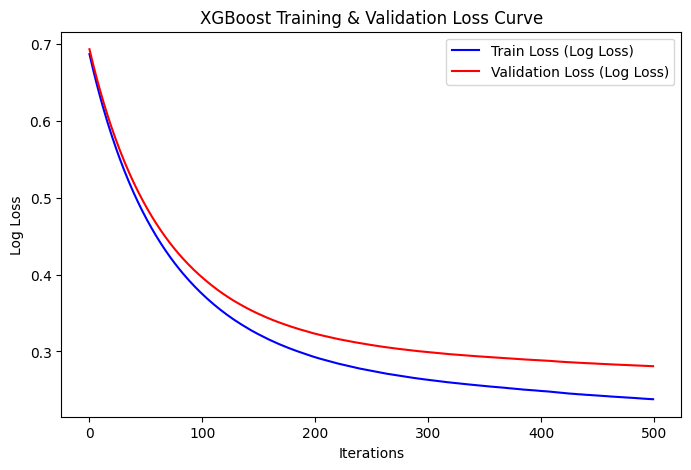

🔹 Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.88      0.92    599114
           1       0.63      0.88      0.74    145192

    accuracy                           0.88    744306
   macro avg       0.80      0.88      0.83    744306
weighted avg       0.90      0.88      0.88    744306



In [118]:
model.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],  # Train & Validation Loss 저장
    verbose=True
)

# 3️⃣ 학습 과정에서 저장된 Train & Validation Loss 가져오기
evals_result = model.evals_result()  # 🔹 변경된 코드 (학습 후 결과 확인)
train_loss = evals_result['validation_0']['logloss']  # Training Loss
val_loss = evals_result['validation_1']['logloss']    # Validation Loss

# 4️⃣ Train & Validation Loss 시각화
plt.figure(figsize=(8, 5))
plt.plot(train_loss, label='Train Loss (Log Loss)', color='blue')
plt.plot(val_loss, label='Validation Loss (Log Loss)', color='red')
plt.xlabel('Iterations')
plt.ylabel('Log Loss')
plt.title('XGBoost Training & Validation Loss Curve')
plt.legend()
plt.show()

# 5️⃣ 예측 및 평가
#y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # ROC Curve & PRC에 필요

threshold = 0.5
y_pred = (y_prob >= threshold).astype(int)

# 🔹 Classification Report 출력
print("🔹 Classification Report:")
print(classification_report(y_test, y_pred))

# 6️⃣ ROC Curve & AUC-ROC 계산
fpr, tpr, _ = roc_curve(y_test, y_prob)
auc_roc = auc(fpr, tpr)

# 7️⃣ Precision-Recall Curve & AU-PRC 계산
precision, recall, _ = precision_recall_curve(y_test, y_prob)
auc_prc = auc(recall, precision)

In [57]:
from sklearn.metrics import confusion_matrix
# confusion matrix 계산
cm = confusion_matrix(y_test, y_pred)

# 행: 실제값 (y_test), 열: 예측값 (y_pred)
# [[TP, FP],
#  [FN, TN]]
TN, FP, FN, TP= cm.ravel()

print("✅ Confusion Matrix")
print(cm)
print(f"\nTrue Positives (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"True Negatives (TN): {TN}")
print(f"False Negatives (FN): {FN}")

✅ Confusion Matrix
[[538368  60746]
 [ 23417 121775]]

True Positives (TP): 121775
False Positives (FP): 60746
True Negatives (TN): 538368
False Negatives (FN): 23417
